# Spacehip Titanic v2

This is my second approach to this kaggle competition.

In [311]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

## Downloading data

In [312]:
TRAIN_DATASET_PATH = "datasets\\spaceship-titanic\\train.csv"
SUBMISSION_DATASET_PATH = "datasets\\spaceship-titanic\\test.csv"

In [313]:
from sklearn.model_selection import train_test_split

test_ratio = 0.2

dataset = pd.read_csv(TRAIN_DATASET_PATH)
train_set, test_set = train_test_split(dataset, test_size=test_ratio)
X_train, y_train = train_set.drop("Transported", axis=1), train_set["Transported"]
X_test, y_test = test_set.drop("Transported", axis=1), test_set["Transported"]

## Data insight

In [314]:
X_train.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name
7117,7585_01,Europa,True,C/281/S,55 Cancri e,31.0,False,0.0,0.0,0.0,0.0,0.0,Suhaino Admingried
8545,9125_02,Mars,True,E/586/P,TRAPPIST-1e,55.0,False,0.0,0.0,0.0,0.0,0.0,Luse Corie
873,0935_01,Earth,False,F/194/P,TRAPPIST-1e,36.0,False,0.0,11.0,0.0,18.0,872.0,Terly Rocknight
7054,7507_03,Earth,False,E/499/S,55 Cancri e,4.0,False,0.0,0.0,0.0,0.0,0.0,Ianley Santin
6563,6924_01,Earth,False,G/1127/S,TRAPPIST-1e,37.0,False,0.0,0.0,0.0,0.0,0.0,Lilasa Solon


In [315]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6954 entries, 7117 to 1020
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   6954 non-null   object 
 1   HomePlanet    6798 non-null   object 
 2   CryoSleep     6773 non-null   object 
 3   Cabin         6796 non-null   object 
 4   Destination   6804 non-null   object 
 5   Age           6817 non-null   float64
 6   VIP           6794 non-null   object 
 7   RoomService   6805 non-null   float64
 8   FoodCourt     6820 non-null   float64
 9   ShoppingMall  6776 non-null   float64
 10  Spa           6811 non-null   float64
 11  VRDeck        6798 non-null   float64
 12  Name          6798 non-null   object 
dtypes: float64(6), object(7)
memory usage: 760.6+ KB


In [316]:
X_train["HomePlanet"].value_counts()

Earth     3719
Europa    1669
Mars      1410
Name: HomePlanet, dtype: int64

In [317]:
X_train["Destination"].value_counts()

TRAPPIST-1e      4696
55 Cancri e      1450
PSO J318.5-22     658
Name: Destination, dtype: int64

In [318]:
print("NaN amount and percentage:")
for column in X_train.columns:
    sum = X_train[column].isnull().sum()
    percent = sum/X_train[column].count()
    print(f"{column:15} {sum:3} \t {percent:.2%}")

NaN amount and percentage:
PassengerId       0 	 0.00%
HomePlanet      156 	 2.29%
CryoSleep       181 	 2.67%
Cabin           158 	 2.32%
Destination     150 	 2.20%
Age             137 	 2.01%
VIP             160 	 2.36%
RoomService     149 	 2.19%
FoodCourt       134 	 1.96%
ShoppingMall    178 	 2.63%
Spa             143 	 2.10%
VRDeck          156 	 2.29%
Name            156 	 2.29%


As we can see there is quite a lot of nan values in each column. We will have to do something with it later.

Let's split the column names into category and numerical columns. This will be helpful later.

In [319]:
cat_cols = []
num_cols = []

for column in X_train.columns:
    if X_train[column].dtype == "object":
        cat_cols.append(column)
    if X_train[column].dtype == "float64":
        num_cols.append(column)

print(cat_cols, num_cols)

['PassengerId', 'HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'VIP', 'Name'] ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']


array([[<AxesSubplot: title={'center': 'Age'}>,
        <AxesSubplot: title={'center': 'RoomService'}>],
       [<AxesSubplot: title={'center': 'FoodCourt'}>,
        <AxesSubplot: title={'center': 'ShoppingMall'}>],
       [<AxesSubplot: title={'center': 'Spa'}>,
        <AxesSubplot: title={'center': 'VRDeck'}>]], dtype=object)

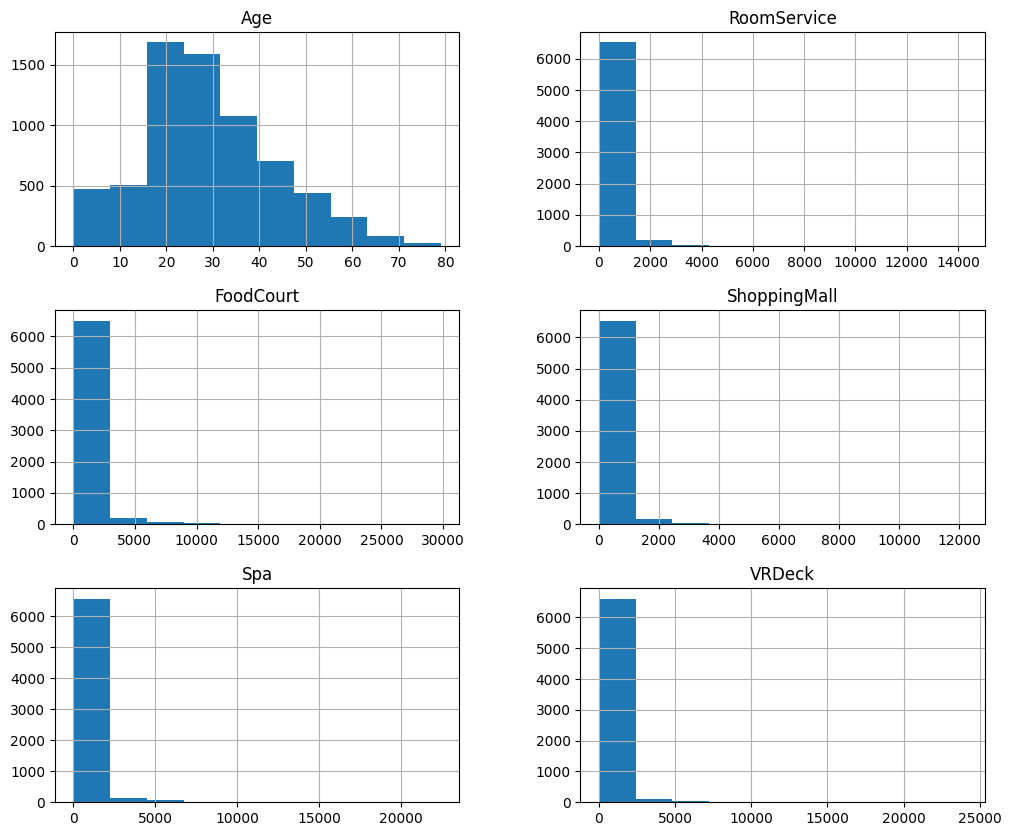

In [320]:
X_train[num_cols].hist(figsize=(12,10))

In [321]:
X_train[num_cols].describe()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,6817.000000,6805.000000,6820.000000,6776.000000,6811.000000,6798.000000
mean,28.889101,225.780015,453.863783,173.414699,305.721627,300.434687
std,14.505342,666.117477,1601.720752,557.527755,1113.827946,1128.912119
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,38.000000,51.000000,69.250000,30.000000,58.000000,50.000000
max,79.000000,14327.000000,29813.000000,12253.000000,22408.000000,24133.000000


As we cann see the histograms don't look like normal distribution at all. 


In fact this data is exponentially distributed. 

I dont know how to deal with it yet, but I'll try to do something aboit it.

## Data preparation

### Data distribution

<AxesSubplot: >

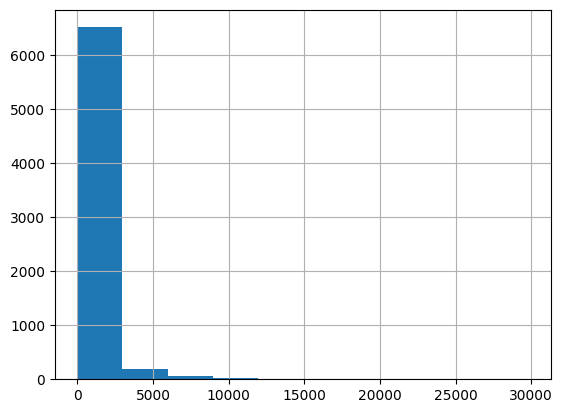

In [322]:
X_train["FoodCourt"].hist()

Percent of -inf values: 64.15%


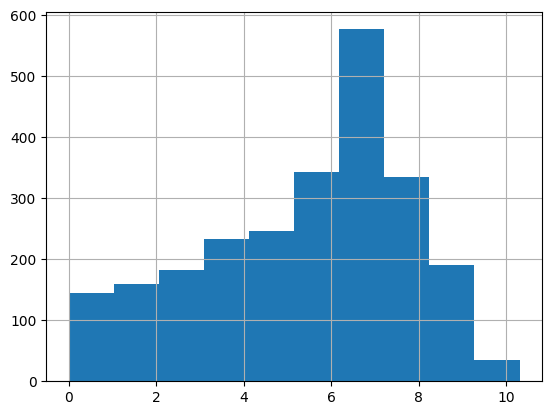

In [323]:
from scipy.stats import boxcox

data = boxcox(X_train["FoodCourt"], 0)
data[data > -np.inf].hist()
inf_perc = data[data == -np.inf].count() / data.count()
print(f"Percent of -inf values: {inf_perc:.2%}")

Boxcox is ineefective because more than half of the records is transformed to -inf.

C:\Users\m.olszanski\AppData\Local\Temp\ipykernel_13676\2932121801.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  X_train[X_train["FoodCourt"] > 0][X_train["FoodCourt"] < 5000]["FoodCourt"].hist()


<AxesSubplot: >

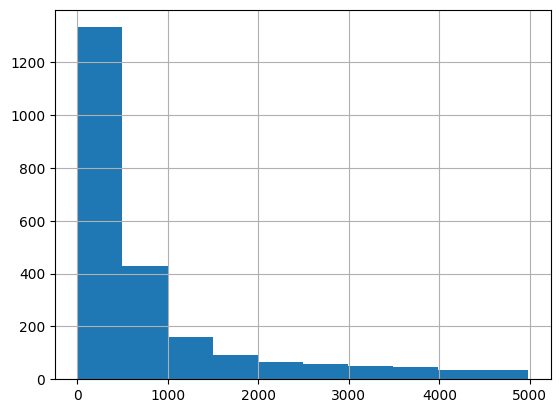

In [324]:
X_train[X_train["FoodCourt"] > 0][X_train["FoodCourt"] < 5000]["FoodCourt"].hist()

In [325]:
corr_matrix = train_set.corr(numeric_only=True)
corr_matrix["Transported"].sort_values(ascending=False)

Transported     1.000000
FoodCourt       0.045463
ShoppingMall   -0.001734
Age            -0.072279
VRDeck         -0.204410
Spa            -0.219774
RoomService    -0.240856
Name: Transported, dtype: float64

I will leave this numerical data as they are. I will only Use standard scaler in the pipeline.

Only RoomService, Spa and VRDeck has a significant negative correlation with the label.

### Categorical values
For the categorical values I will use the One-Hot-Encoding. I will also create a custom transformer to extract the "Deck" value from "Cabin"column.

In [326]:
from sklearn.base import BaseEstimator, TransformerMixin
from copy import deepcopy

class SeatInfoAdder(BaseEstimator, TransformerMixin):
    
    def __init__(self, only_deck=True):
        self.only_deck = only_deck
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        
        X_new = deepcopy(X)
        X_new["deck"] =  X_new['Cabin'].str.split('/', n=2, expand=True)[0]
        
        if self.only_deck:
            return X_new
        else:
            print(X_new)
            X_new["num"], X_new["side"] = X_new['Cabin'].str.split('/', n=2, expand=True)[1:]
            return X_new

We also have to do something with the missing categorical values (for numerical we simply use the median value imputer).

I will implement the transformer that replces missing categorical values with the most frequent ones.

In [327]:
class CategoricalImputer(BaseEstimator, TransformerMixin):
    
    def __init__(self, strategy="most_freq", value=None):
        """ 
        Imputer for replacing missing categorical values.

        Args:
            strategy (str): Strategy that the imputer will use to replace missing values:
                - most_freq - replacing with the most frequent values
                - constant - replacing with the contant value (provided as a second argument)
                - drop - dropping the rows with missingn value
            
            value (str): Value that imputer will use to replace value, if the "contant" strategy
                is used.                
        """
        accepteed_strategies = ["most_freq", "constant", "drop"]
        if strategy in accepteed_strategies:
            self.strategy = strategy
        else:
            raise ValueError('Wrong strategy used. Please choose one of the following: "most_freq", "constant", "drop".' )
        
        if self.strategy == "constant" and value is None:
           raise ValueError('Value of "value" argument is None, and when used with "constant" strategy it cannot be None')
        else: 
            self.value = value
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        X_new = deepcopy(X)
        
        for column in X_new.columns:
            mask = X_new[column].isna()
            
            if self.strategy == "most_freq":
                freq_value = X_new[column].mode()[0]
                X_new.loc[mask, column] = freq_value
            elif self.strategy == "constant":
                X_new.loc[mask, column] = self.value
            elif self.strategy == "drop":
                X_new = X_new.dropna(axis=0)
            
        return X_new

### Creating Transforming Pipeline

In [328]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

num_pipeline = Pipeline([
    ("sim_imp", SimpleImputer()),
    ("std_scaler", StandardScaler()),
])

cat_pipeline = Pipeline([
    ("cat_imp", CategoricalImputer()),
    ("seat_adder", SeatInfoAdder()),
    ("one_hot", OneHotEncoder())
])

transform_pipeline = ColumnTransformer([
    ("num_tr", num_pipeline, num_cols),
    ("cat_tr", cat_pipeline, cat_cols),
])

In [329]:
cat_cols

['PassengerId',
 'HomePlanet',
 'CryoSleep',
 'Cabin',
 'Destination',
 'VIP',
 'Name']

## Model selection

In [330]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

forest = RandomForestClassifier()

full_pipeline = Pipeline([
    ("transform", transform_pipeline),
    ("forest_clf", forest)
])

params = {
    "forest_clf__n_estimators": [100, 200],
    # "transform__cat_tr__seat_adder__only_deck": [True]
}

grid_CV = GridSearchCV(full_pipeline, params, cv=3, verbose=3, scoring="f1")
grid_CV.fit(X_train, y_train)

Fitting 3 folds for each of 2 candidates, totalling 6 fits


c:\Users\m.olszanski\Desktop\Bench_projects\ML_basics\env\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\m.olszanski\Desktop\Bench_projects\ML_basics\env\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\m.olszanski\Desktop\Bench_projects\ML_basics\env\lib\site-packages\sklearn\metrics\_scorer.py", line 219, in __call__
    return self._score(
  File "c:\Users\m.olszanski\Desktop\Bench_projects\ML_basics\env\lib\site-packages\sklearn\metrics\_scorer.py", line 261, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "c:\Users\m.olszanski\Desktop\Bench_projects\ML_basics\env\lib\site-packages\sklearn\metrics\_scorer.py", line 71, in _cached_call
    return getattr(estimator, method)(*args, **kwarg

[CV 1/3] END ........forest_clf__n_estimators=100;, score=nan total time=  10.1s


c:\Users\m.olszanski\Desktop\Bench_projects\ML_basics\env\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\m.olszanski\Desktop\Bench_projects\ML_basics\env\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\m.olszanski\Desktop\Bench_projects\ML_basics\env\lib\site-packages\sklearn\metrics\_scorer.py", line 219, in __call__
    return self._score(
  File "c:\Users\m.olszanski\Desktop\Bench_projects\ML_basics\env\lib\site-packages\sklearn\metrics\_scorer.py", line 261, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "c:\Users\m.olszanski\Desktop\Bench_projects\ML_basics\env\lib\site-packages\sklearn\metrics\_scorer.py", line 71, in _cached_call
    return getattr(estimator, method)(*args, **kwarg

[CV 2/3] END ........forest_clf__n_estimators=100;, score=nan total time=  12.5s


c:\Users\m.olszanski\Desktop\Bench_projects\ML_basics\env\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\m.olszanski\Desktop\Bench_projects\ML_basics\env\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\m.olszanski\Desktop\Bench_projects\ML_basics\env\lib\site-packages\sklearn\metrics\_scorer.py", line 219, in __call__
    return self._score(
  File "c:\Users\m.olszanski\Desktop\Bench_projects\ML_basics\env\lib\site-packages\sklearn\metrics\_scorer.py", line 261, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "c:\Users\m.olszanski\Desktop\Bench_projects\ML_basics\env\lib\site-packages\sklearn\metrics\_scorer.py", line 71, in _cached_call
    return getattr(estimator, method)(*args, **kwarg

[CV 3/3] END ........forest_clf__n_estimators=100;, score=nan total time=  10.7s


c:\Users\m.olszanski\Desktop\Bench_projects\ML_basics\env\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\m.olszanski\Desktop\Bench_projects\ML_basics\env\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\m.olszanski\Desktop\Bench_projects\ML_basics\env\lib\site-packages\sklearn\metrics\_scorer.py", line 219, in __call__
    return self._score(
  File "c:\Users\m.olszanski\Desktop\Bench_projects\ML_basics\env\lib\site-packages\sklearn\metrics\_scorer.py", line 261, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "c:\Users\m.olszanski\Desktop\Bench_projects\ML_basics\env\lib\site-packages\sklearn\metrics\_scorer.py", line 71, in _cached_call
    return getattr(estimator, method)(*args, **kwarg

[CV 1/3] END ........forest_clf__n_estimators=200;, score=nan total time=  21.3s


c:\Users\m.olszanski\Desktop\Bench_projects\ML_basics\env\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\m.olszanski\Desktop\Bench_projects\ML_basics\env\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\m.olszanski\Desktop\Bench_projects\ML_basics\env\lib\site-packages\sklearn\metrics\_scorer.py", line 219, in __call__
    return self._score(
  File "c:\Users\m.olszanski\Desktop\Bench_projects\ML_basics\env\lib\site-packages\sklearn\metrics\_scorer.py", line 261, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "c:\Users\m.olszanski\Desktop\Bench_projects\ML_basics\env\lib\site-packages\sklearn\metrics\_scorer.py", line 71, in _cached_call
    return getattr(estimator, method)(*args, **kwarg

[CV 2/3] END ........forest_clf__n_estimators=200;, score=nan total time=  21.6s


c:\Users\m.olszanski\Desktop\Bench_projects\ML_basics\env\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\m.olszanski\Desktop\Bench_projects\ML_basics\env\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\m.olszanski\Desktop\Bench_projects\ML_basics\env\lib\site-packages\sklearn\metrics\_scorer.py", line 219, in __call__
    return self._score(
  File "c:\Users\m.olszanski\Desktop\Bench_projects\ML_basics\env\lib\site-packages\sklearn\metrics\_scorer.py", line 261, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "c:\Users\m.olszanski\Desktop\Bench_projects\ML_basics\env\lib\site-packages\sklearn\metrics\_scorer.py", line 71, in _cached_call
    return getattr(estimator, method)(*args, **kwarg

[CV 3/3] END ........forest_clf__n_estimators=200;, score=nan total time=  20.9s


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('transform',
                                        ColumnTransformer(transformers=[('num_tr',
                                                                         Pipeline(steps=[('sim_imp',
                                                                                          SimpleImputer()),
                                                                                         ('std_scaler',
                                                                                          StandardScaler())]),
                                                                         ['Age',
                                                                          'RoomService',
                                                                          'FoodCourt',
                                                                          'ShoppingMall',
                                                                          'Spa',
                                                                          'VRDeck']),
                                                                        ('cat_tr',
                                                                         Pipeline(steps=[('cat_imp',
                                                                                          CategoricalImputer()),
                                                                                         ('seat_adder',
                                                                                          SeatInfoAdder()),
                                                                                         ('one_hot',
                                                                                          OneHotEncoder())]),
                                                                         ['PassengerId',
                                                                          'HomePlanet',
                                                                          'CryoSleep',
                                                                          'Cabin',
                                                                          'Destination',
                                                                          'VIP',
                                                                          'Name'])])),
                                       ('forest_clf',
                                        RandomForestClassifier())]),
             param_grid={'forest_clf__n_estimators': [100, 200]}, scoring='f1',
             verbose=3)

In [331]:
y_train

7117     True
8545     True
873     False
7054     True
6563     True
        ...  
3027     True
6422     True
3131    False
7985     True
1020    False
Name: Transported, Length: 6954, dtype: bool